The goal of this demo is to contextualize a schizophrenia atrophy map with respect to other brain maps

**General things**

In [1]:
# Import statements
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from nilearn.plotting import plot_stat_map

# Set-up matplotlib properties
flierprops = dict(marker='+',
                  markerfacecolor='lightgray',
                  markeredgecolor='lightgray')
medianprops = dict(color='black')
plt.rcParams.update({'axes.spines.top': False})
plt.rcParams.update({'axes.spines.right': False})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'Calibri'})
plt.rcParams.update({'font.weight': 'light'})

**Load our atrophy map**

C:\Users\vince\anaconda3\lib\site-packages\nilearn\plotting\img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


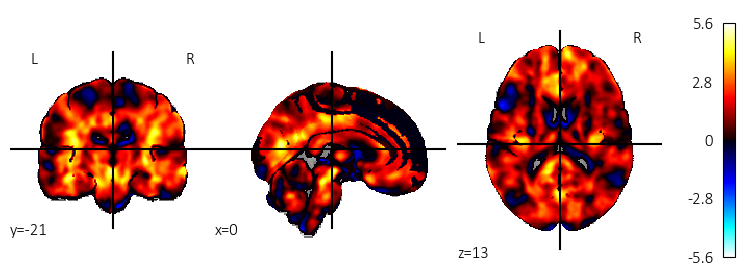

In [2]:
NUSDAST_mni152 = nib.load('nusdast_zmap_mni.nii')
plot_stat_map(NUSDAST_mni152)

**Transform the atrophy map to fsaverage6 (41k)**

In [3]:
from neuromaps import transforms

# Do the transformation
gii_images = transforms.mni152_to_fsaverage(NUSDAST_mni152,
                                            fsavg_density='41k')

Let's set values in the medial wall to NaN

In [4]:
from neuromaps import datasets, images

NUSDAST_fs41k = []
medial_wall = datasets.fetch_atlas('fsaverage', '41k')['medial']
for mask_gii, hemi_gii in zip(medial_wall, gii_images):
    mwall_mask = nib.load(mask_gii).agg_data()
    hemi_data = hemi_gii.agg_data()
    hemi_data[mwall_mask == 0] = np.nan
    NUSDAST_fs41k.append(images.construct_shape_gii(hemi_data))

In [5]:
print(NUSDAST_fs41k)

[<nibabel.gifti.gifti.GiftiImage object at 0x00000239BE17BA00>, <nibabel.gifti.gifti.GiftiImage object at 0x00000239BE17BAF0>]


**Generate 1000 null maps | Takes about 15 minutes to run**

In [6]:
from neuromaps import nulls

null_maps = nulls.alexander_bloch(
    NUSDAST_fs41k, atlas='fsaverage', density='41k', n_perm=1000)

load the pre-generated null maps

In [7]:
null_maps = np.load('demo_results/NUSDAST_fsaverage_41k_nulls.npy')

**Compare our atrophy data with images in our repository that are originally in
surface space**

Fetch brain maps

In [8]:
surface_annotations = datasets.fetch_annotation(space=['fsaverage', 'civet', 'fsLR'])
del surface_annotations[('hill2010', 'devexp', 'fsLR', '164k')]
del surface_annotations[('hill2010', 'evoexp', 'fsLR', '164k')]

Transform brain maps to fsaverage 41k

In [9]:
from neuromaps import resampling

fsaverage_41k_annotations = {}
for (source, desc, space, den), annotation in surface_annotations.items():

    print(f"{source} | {desc} | {space} | {den}")

    fsaverage_41k_annotations[f"{source} | {desc}"], _ = resampling.resample_images(
        src=annotation,
        trg=NUSDAST_fs41k,
        src_space=space,
        trg_space='fsaverage',
        resampling='transform_to_trg')

abagen | genepc1 | fsaverage | 10k
beliveau2017 | az10419369 | fsaverage | 164k
beliveau2017 | cimbi36 | fsaverage | 164k
beliveau2017 | cumi101 | fsaverage | 164k
beliveau2017 | dasb | fsaverage | 164k
beliveau2017 | sb207145 | fsaverage | 164k
hcps1200 | megalpha | fsLR | 4k
hcps1200 | megbeta | fsLR | 4k
hcps1200 | megdelta | fsLR | 4k
hcps1200 | meggamma1 | fsLR | 4k
hcps1200 | meggamma2 | fsLR | 4k
hcps1200 | megtheta | fsLR | 4k
hcps1200 | megtimescale | fsLR | 4k
hcps1200 | myelinmap | fsLR | 32k
hcps1200 | thickness | fsLR | 32k
margulies2016 | fcgradient01 | fsLR | 32k
margulies2016 | fcgradient02 | fsLR | 32k
margulies2016 | fcgradient03 | fsLR | 32k
margulies2016 | fcgradient04 | fsLR | 32k
margulies2016 | fcgradient05 | fsLR | 32k
margulies2016 | fcgradient06 | fsLR | 32k
margulies2016 | fcgradient07 | fsLR | 32k
margulies2016 | fcgradient08 | fsLR | 32k
margulies2016 | fcgradient09 | fsLR | 32k
margulies2016 | fcgradient10 | fsLR | 32k
mueller2013 | intersubjvar | fsLR | 1

**Compute the correlations + assess significance with random permutations**

Generate random permutations

In [11]:
NUSDAST_fs41k_data = images.load_data(NUSDAST_fs41k)
random_permutations = np.array(
    [np.random.permutation(NUSDAST_fs41k_data) for _ in range(1000)]).T

Compute the correlations

In [ ]:
from neuromaps import stats

r_all, p_all, r_nulls_all = [], [], []
for annotation in fsaverage_41k_annotations.values():
    r, p, r_nulls = stats.compare_images(NUSDAST_fs41k,
                                         annotation,
                                         nulls=random_permutations,
                                         nan_policy='omit',
                                         metric='pearsonr',
                                         return_nulls=True)
    r_all.append(r)
    p_all.append(p)
    r_nulls_all.append(r_nulls)

Load the pre-computed correlation values

In [12]:
r_all = np.load('demo_results/NUSDAST_r.npy')
r_all_nulls = np.load('demo_results/NUSDAST_r_perm.npy')
p_all = np.load('demo_results/NUSDAST_r_perm.npy')

Visualize the results

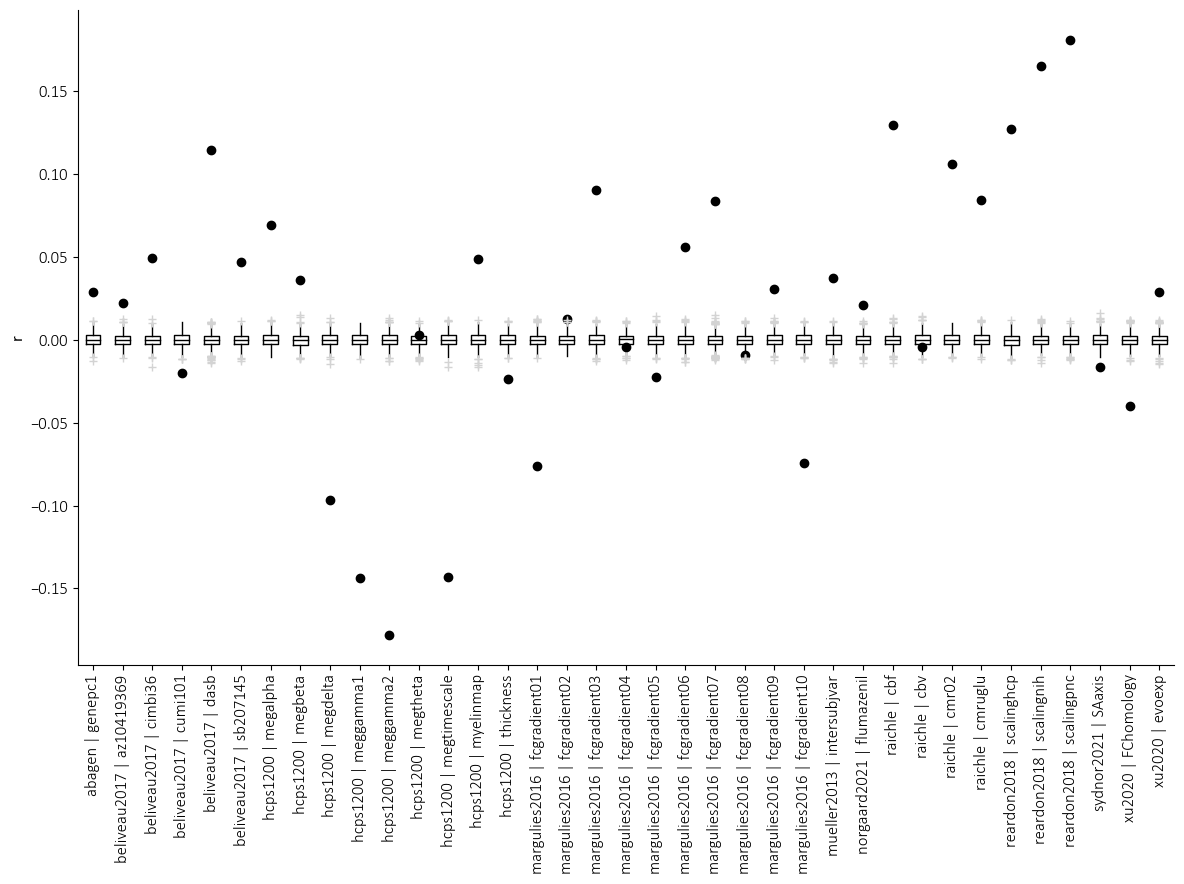

In [13]:
plt.figure(figsize=(12, 9))
plt.ylabel("r")
plt.boxplot(r_all_nulls.T, flierprops=flierprops, medianprops=medianprops,
            showcaps=False)
plt.xticks(np.arange(1, 38), fsaverage_41k_annotations.keys(), rotation='vertical')
plt.ylabel("r")
plt.scatter(np.arange(1,38), r_all, color='black')
plt.tight_layout()

**Compute the correlations: now let's try with our spatial
autocorrelation-preserving surrogate annotations**

In [ ]:
r_all, p_all, r_all_nulls = [], [], []
for annotation in fsaverage_41k_annotations.values():
    r, p, r_nulls = stats.compare_images(NUSDAST_fs41k,
                                         annotation,
                                         nulls=null_maps,
                                         nan_policy='omit',
                                         metric='pearsonr',
                                         return_nulls=True)
    r_all.append(r)
    p_all.append(p)
    r_all_nulls.append(r_nulls)

load the pre-computed correlations

In [14]:
r_all = np.load('demo_results/NUSDAST_r.npy')
r_all_nulls = np.load('demo_results/NUSDAST_r_spin.npy')
p_all = np.load('demo_results/NUSDAST_p_spin.npy')

visualize the results

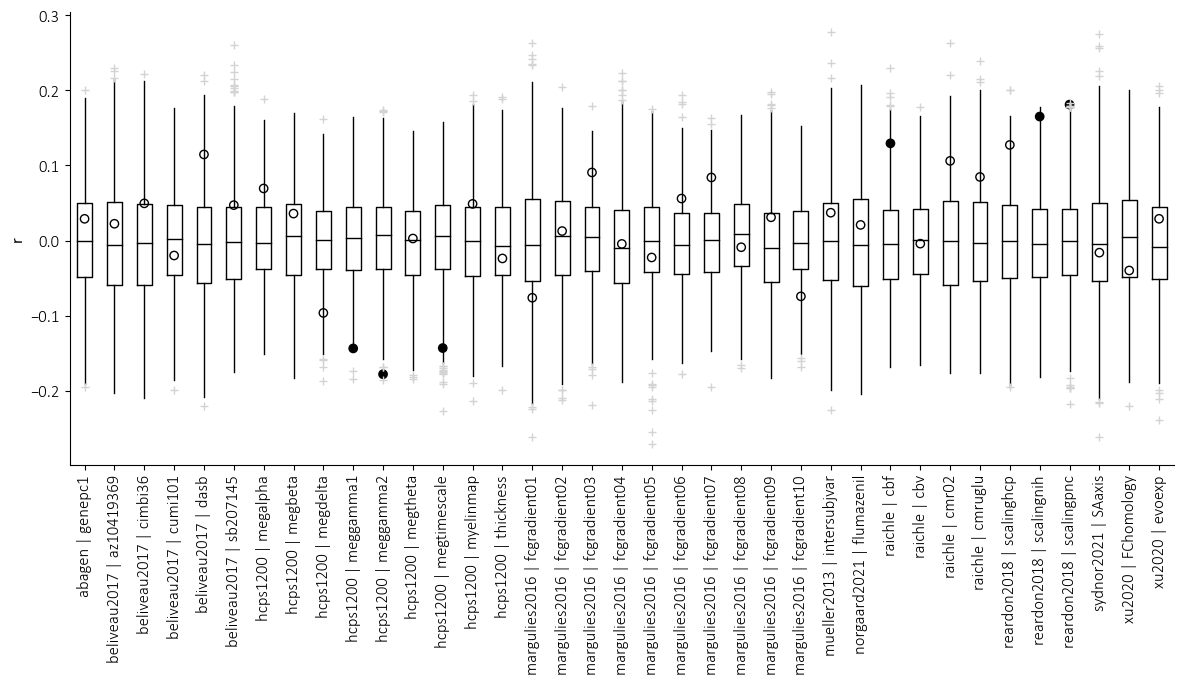

In [15]:
plt.figure(figsize=(12, 7))
plt.ylabel("r")
plt.boxplot(r_all_nulls.T, flierprops=flierprops, medianprops=medianprops,
            showcaps=False)
plt.xticks(np.arange(1, 38), fsaverage_41k_annotations.keys(), rotation='vertical')
plt.ylabel("r")
plt.scatter(np.arange(1,38), r_all, cmap='binary', c=p_all<0.05, edgecolors='black')
plt.tight_layout()